# Discovering transmorph basics

This tutorial will demonstrate how to perform basic data integration using transmorph. We will use two spiraling datasets in order to test different transmorph options. All datasets used in this tutorial are available on transmorph's [GitHub](https://github.com/Risitop/transmorph/tree/documentation/docs/tutorial/data).


## Synthetic datasets

Let us start by loading our two datasets.

In [53]:
import numpy as np

In [5]:
X = np.loadtxt("data/spiralA.csv", delimiter=",")
Y = np.loadtxt("data/spiralB.csv", delimiter=",")
X.shape, Y.shape

((433, 3), (663, 3))

We can then compute and plot them in a 2-PC space in order to get a closer look.

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=2)
pca = pca.fit(Y)

In [10]:
import matplotlib.pyplot as plt

In [41]:
# Plotting parameters

dotsize = 40
qcolor = 'royalblue' # query
qmarker = 's'
rcolor = 'crimson' # reference
rmarker = 'o'
icolor = 'yellow' # integrated
imarker = 'D'
x_label = 'PC1'
y_label = 'PC2'
titlesize = 15
labelsize = 15
legendsize = 10

In [46]:
# Plotting function

def plot_datasets(*datasets, 
                   title=None,
                   x_label=None,
                   y_label=None,
                   enable_cbar=False,
                   cbar_title=None,
                   **kwargs):
    for dataset in datasets:
        X = dataset['X']
        color = dataset['c']
        kwargs_to_pass = {k: dataset[k] for k in dataset if k not in ('X', 'c')}
        plt.scatter(*X.T, c=color, **kwargs_to_pass, **kwargs)
    if x_label is not None:
        plt.xlabel(x_label, size=labelsize)
    if y_label is not None:
        plt.ylabel(y_label, size=labelsize)
    if any("label" in dataset for dataset in datasets):
        plt.legend(fontsize=legendsize)
    plt.xticks([])
    plt.yticks([])
    
    if enable_cbar:
        cbar = plt.colorbar()
        if cbar_title is not None:
            cbar.ax.set_ylabel(cbar_title, fontsize=labelsize)
    
    if title is not None:
        plt.title(title, fontsize=titlesize)

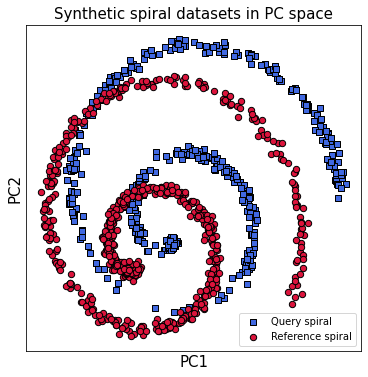

In [47]:
plt.figure(figsize=(6,6))
plot_datasets({
                   "X": pca.transform(X), 
                   "label": "Query spiral",
                   "c": qcolor,
                   "marker": qmarker
               }, 
               {
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
               title="Synthetic spiral datasets in PC space",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

We see two datasets in a spiraling fashion. We also observe the query dataset to present "holes" in the manifold, that integration method will have to account for.

## Dataset integration

Let us load a transmorph object to perform dataset integration. We will try out and compare different parameters.

In [54]:
import transmorph as tr
import time

### 1. Basic parameters

In [56]:
t_start = time.time()
transmorph_base = tr.Transmorph() # Create a default transmorph
X_integrated_base = transmorph_base.fit_transform(X, Y)
print("Elapsed:", time.time() - t_start, "seconds")

Elapsed: 0.057901620864868164 seconds


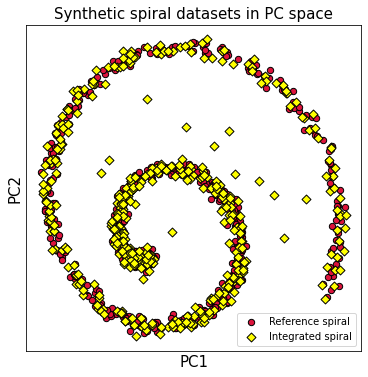

In [42]:
plt.figure(figsize=(6,6))
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_base), 
                   "label": "Integrated spiral",
                   "c": icolor,
                   "marker": imarker
               }, 
               title="Synthetic spiral datasets in PC space",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

As we can see, integration is quite decent in terms of shape. What we can do to further assess integration quality is to compare the initial position of each point along the spiral manifold to its final position. Let us load point labels. 

In [43]:
lbl_X = np.loadtxt("data/spiralA_labels.csv", delimiter=",")
lbl_Y = np.loadtxt("data/spiralB_labels.csv", delimiter=",")

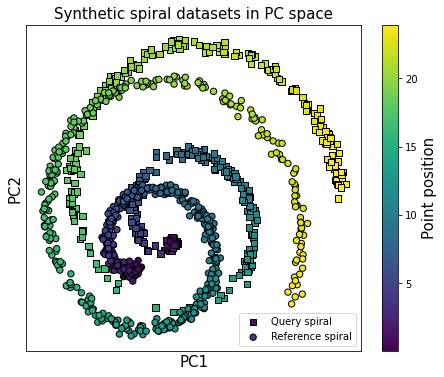

In [51]:
plt.figure(figsize=(7.5,6))
plot_datasets({
                   "X": pca.transform(X), 
                   "label": "Query spiral",
                   "c": lbl_X,
                   "marker": qmarker
               }, 
               {
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": lbl_Y,
                   "marker": rmarker
               }, 
               title="Synthetic spiral datasets in PC space",
               x_label=x_label,
               y_label=y_label,
                enable_cbar=True,
                cbar_title="Point position",
               ec='k', 
               s=dotsize)

As expected, we observe in each dataset a smooth position gradient. Let us compare with after integration. 

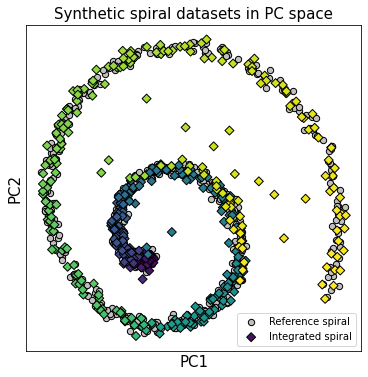

In [52]:
plt.figure(figsize=(6,6))
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": 'silver',
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_base), 
                   "label": "Integrated spiral",
                   "c": lbl_X,
                   "marker": imarker
               }, 
               title="Synthetic spiral datasets in PC space",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

The result is quite underwhelming. Even if the integration is decent shape-wise, as we can see plenty of external points mapped into the internal region. Avoiding such case (called "overcorrection") is critical in real-life applications, as this leads to a misleading integration. Let us try to do better.

### 2. Weights correction

We can suspect dataset unbalance to be responsible for integration issues: as we have observed, the query dataset is full of "holes", with higher density regions, while the reference one is quite continuous. Fortunately, transmorph features a weight adjustement pre-processing in order to deal with such cases of dataset unbalance. To enable it, we have to set the parameter *weighting_strategy* to *"woti"*.

In [58]:
t_start = time.time()
transmorph_weighted = tr.Transmorph(weighting_strategy='woti')
X_integrated_woti = transmorph_weighted.fit_transform(X, Y)
print("Elapsed:", time.time() - t_start, "seconds")

Elapsed: 0.6358547210693359 seconds


Let us start by observing the shape of the integrated dataset.

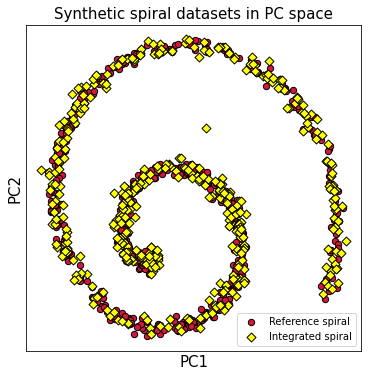

In [59]:
plt.figure(figsize=(6,6))
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_woti), 
                   "label": "Integrated spiral",
                   "c": icolor,
                   "marker": imarker
               }, 
               title="Synthetic spiral datasets in PC space",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

This already seems to be better. Let us observe how the position gradients look like.

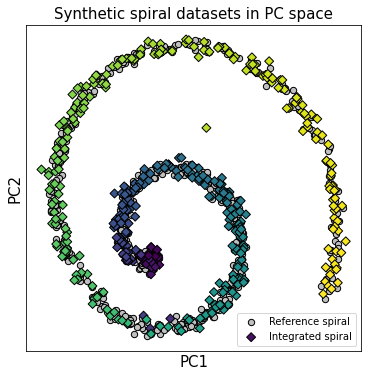

In [60]:
plt.figure(figsize=(6,6))
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": 'silver',
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_woti), 
                   "label": "Integrated spiral",
                   "c": lbl_X,
                   "marker": imarker
               }, 
               title="Synthetic spiral datasets in PC space",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

There are still a few miscorrected points, but this is already much more convincing. In this tutorial, we showed how monitoring the weighting strategy can improve integration quality.